<a href="https://colab.research.google.com/github/raphael-fawaz/Financial-Markets-Analysis-and-Prediction/blob/Bi-LSTM-(Dow-Jones-%26-Nasdaq)---Close-Price/LSTM_(EGX30)_Multiple_Features_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSTM (EGX30) Multiple Features Prediction

In [ ]:
import pandas as pd
import numpy as np
import io

import matplotlib.pyplot as plt
import seaborn as sns
import mplfinance as mpf
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from pandas.plotting import lag_plot

## Data pre-processing

In [ ]:
EGX30 = pd.read_csv('EGX 30 Data June.csv',parse_dates=['Date'])

In [ ]:
def convert_volume_to_float(volume_str):
    if pd.isna(volume_str):
        return np.nan
    else:
        return float(volume_str[:-1]) * 1e6

def convert_change_to_float(change_str):
    if pd.isna(change_str):
        return np.nan
    else:
        return float(change_str[:-1]) /100

In [ ]:
EGX30['Date'] = pd.to_datetime(EGX30['Date'])

EGX30 = EGX30.dropna()

num_cols = ['Price', 'Open', 'High', 'Low']
for col in num_cols:
    EGX30[col] = EGX30[col].str.replace(',', '').astype(float)

EGX30['Vol.'] = EGX30['Vol.'].apply(convert_volume_to_float)
EGX30['Change %']= EGX30['Change %'].apply(convert_change_to_float)

# Set the 'Date' column as the index
EGX30.set_index('Date', inplace=True)

#Change the name of the price column to close.
EGX30.rename(columns={'Price': 'Close'}, inplace=True)

EGX30.head()

,Close,Open,High,Low,Vol.,Change %
Date,,,,,,
2024-06-05,26634.30,26915.46,26915.46,26245.33,240860000.0,-0.0126
2024-06-04,26973.00,26852.33,27158.65,26852.33,352590000.0,0.0052
2024-06-03,26834.47,26869.85,27003.04,26760.84,267860000.0,-0.0013
2024-06-02,26869.85,26922.76,27140.20,26753.70,225280000.0,-0.0020
2024-05-30,26922.76,27089.68,27116.25,26683.97,352590000.0,-0.0062


In [ ]:
EGX30 = EGX30[::-1]

In [ ]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
egx30_scaled = scaler.fit_transform(EGX30)

In [ ]:
def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length])
        labels.append(data[i+seq_length])  # Include all features for the label
    return np.array(sequences), np.array(labels)

In [ ]:
# Create sequences
seq_length = 60  # Use 60 days of data to predict the next day's price
egx30_sequences, egx30_labels = create_sequences(egx30_scaled, seq_length)

# Determine the index to split the data for the test set (last 60 days)
test_size = 60
train_sequences = egx30_sequences[:-test_size]
test_sequences = egx30_sequences[-test_size:]
train_labels = egx30_labels[:-test_size]
test_labels = egx30_labels[-test_size:]

## Single Layer LSTM

In [ ]:
# Build the LSTM model
model = Sequential([
    LSTM(50, return_sequences=False, input_shape=(seq_length, egx30_scaled.shape[1])),
    Dropout(0.2),
    Dense(egx30_scaled.shape[1])  # Predicting all features
])

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(train_sequences, train_labels, epochs=20, batch_size=32, validation_split=0.2)


Epoch 1/20
90/90 [==============================] - 6s 38ms/step - loss: 0.0143 - val_loss: 0.0040
Epoch 2/20
90/90 [==============================] - 3s 29ms/step - loss: 0.0052 - val_loss: 0.0024
Epoch 3/20
90/90 [==============================] - 3s 29ms/step - loss: 0.0044 - val_loss: 0.0024
Epoch 4/20
90/90 [==============================] - 3s 29ms/step - loss: 0.0040 - val_loss: 0.0028
Epoch 5/20
90/90 [==============================] - 3s 29ms/step - loss: 0.0037 - val_loss: 0.0031
Epoch 6/20
90/90 [==============================] - 3s 29ms/step - loss: 0.0035 - val_loss: 0.0036
Epoch 7/20
90/90 [==============================] - 3s 29ms/step - loss: 0.0038 - val_loss: 0.0024
Epoch 8/20
90/90 [==============================] - 3s 29ms/step - loss: 0.0033 - val_loss: 0.0023
Epoch 9/20
90/90 [==============================] - 3s 29ms/step - loss: 0.0031 - val_loss: 0.0027
Epoch 10/20
90/90 [==============================] - 3s 28ms/step - loss: 0.0031 - val_loss: 0.0025
Epoch 11/

## Prediction Evaluation

In [ ]:
# Predict on the test data
predictions = model.predict(test_sequences)


# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test_labels, predictions))
print(f'Root Mean Squared Error: {rmse}')

2/2 [==============================] - 1s 8ms/step
Root Mean Squared Error: 0.07965691943730735


## Prediction for the next 30 days

1/1 [==============================] - 0s 24ms/step
Predicted EGX30 'Close' Prices for the Next 30 Days:
2024-06-06: 25766.13
2024-06-07: 25596.64
2024-06-08: 25380.84
2024-06-09: 25149.54
2024-06-10: 24908.48
2024-06-11: 24661.74
2024-06-12: 24412.33
2024-06-13: 24162.46
2024-06-14: 23913.73
2024-06-15: 23667.32
2024-06-16: 23424.07
2024-06-17: 23184.56
2024-06-18: 22949.17
2024-06-19: 22718.15
2024-06-20: 22491.64
2024-06-21: 22269.70
2024-06-22: 22052.34
2024-06-23: 21839.51
2024-06-24: 21631.17
2024-06-25: 21427.22
2024-06-26: 21227.58
2024-06-27: 21032.14
2024-06-28: 20840.78
2024-06-29: 20653.40
2024-06-30: 20469.89
2024-07-01: 20290.14
2024-07-02: 20114.04
2024-07-03: 19941.49
2024-07-04: 19772.37
2024-07-05: 19606.61


C:\Users\Rapha\AppData\Local\Temp\ipykernel_18660\3154149647.py:22: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  next_dates = pd.date_range(start=last_date, periods=31, closed='right')


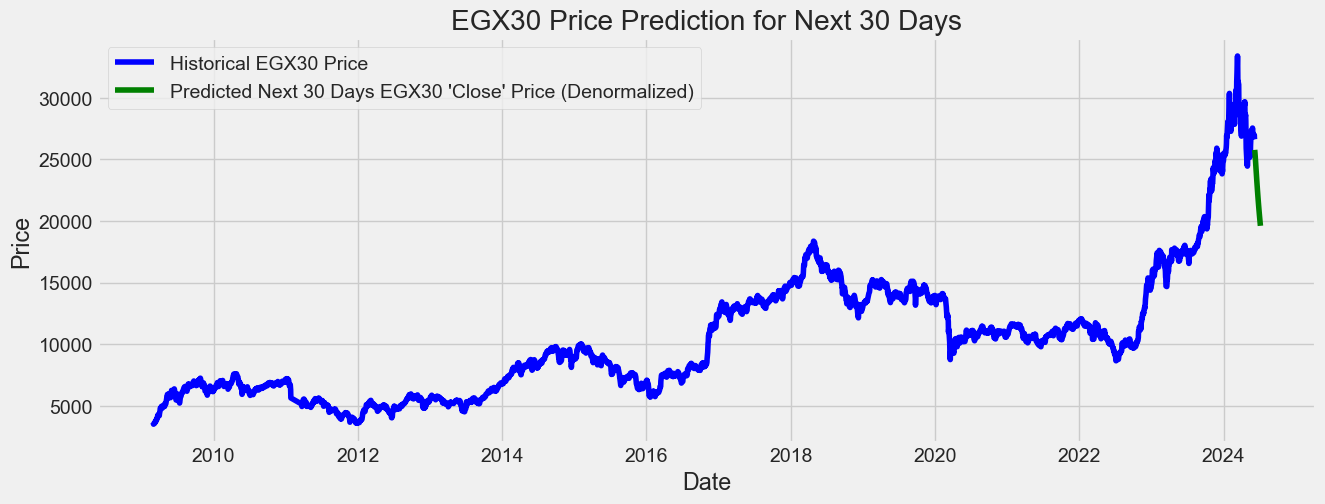

In [ ]:
last_sequence = egx30_scaled[-seq_length:]  # Last 60 days of scaled data
next_30_days = []

for _ in range(30):
    next_day_pred = model.predict(last_sequence.reshape(1, seq_length, egx30_scaled.shape[1]))
    next_30_days.append(next_day_pred[0])  # Predicting all features
    next_day_scaled = next_day_pred[0]
    last_sequence = np.append(last_sequence[1:], next_day_scaled.reshape(1, -1), axis=0)

# Extract only the 'Close' prices from the predicted data for plotting
next_30_days_close = [day[0] for day in next_30_days]

# Create an array with the same number of features as the original data, filling the other features with zeros
next_30_days_full = np.zeros((len(next_30_days_close), egx30_scaled.shape[1]))
next_30_days_full[:, 0] = next_30_days_close  # Place 'Close' prices in the correct column

# Denormalize the predicted prices
next_30_days_denormalized = scaler.inverse_transform(next_30_days_full)[:, 0]

# Create a date range for the next 30 days
last_date = EGX30.index[-1]
next_dates = pd.date_range(start=last_date, periods=31, closed='right')

# Print the predicted prices for the next 30 days
print("Predicted EGX30 'Close' Prices for the Next 30 Days:")
for date, price in zip(next_dates, next_30_days_denormalized):
    print(f"{date.date()}: {price:.2f}")

# Plot the next 30 days predictions
plt.figure(figsize=(14, 5))
plt.plot(EGX30.index, EGX30['Close'], color='blue', label='Historical EGX30 Price')
plt.plot(next_dates, next_30_days_denormalized, color='green', label="Predicted Next 30 Days EGX30 'Close' Price (Denormalized)")
plt.title('EGX30 Price Prediction for Next 30 Days')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

1/1 [==============================] - 0s 24ms/step
Predicted EGX30 'Close' Prices for the Next 30 Days:
2024-06-06: 25766.13
2024-06-07: 25596.64
2024-06-08: 25380.84
2024-06-09: 25149.54
2024-06-10: 24908.48
2024-06-11: 24661.74
2024-06-12: 24412.33
2024-06-13: 24162.46
2024-06-14: 23913.73
2024-06-15: 23667.32
2024-06-16: 23424.07
2024-06-17: 23184.56
2024-06-18: 22949.17
2024-06-19: 22718.15
2024-06-20: 22491.64
2024-06-21: 22269.70
2024-06-22: 22052.34
2024-06-23: 21839.51
2024-06-24: 21631.17
2024-06-25: 21427.22
2024-06-26: 21227.58
2024-06-27: 21032.14
2024-06-28: 20840.78
2024-06-29: 20653.40
2024-06-30: 20469.89
2024-07-01: 20290.14
2024-07-02: 20114.04
2024-07-03: 19941.49
2024-07-04: 19772.37
2024-07-05: 19606.61


C:\Users\Rapha\AppData\Local\Temp\ipykernel_18660\393690928.py:23: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  next_dates = pd.date_range(start=last_date, periods=31, closed='right')


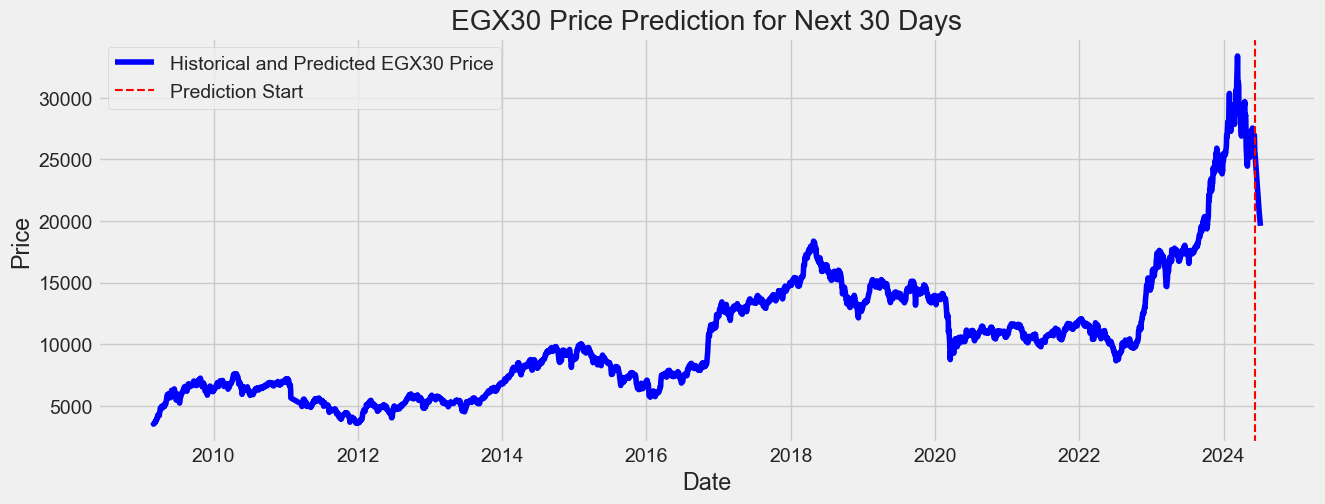

In [ ]:
# Predict the next 30 days
last_sequence = egx30_scaled[-seq_length:]  # Last 60 days of scaled data
next_30_days = []

for _ in range(30):
    next_day_pred = model.predict(last_sequence.reshape(1, seq_length, egx30_scaled.shape[1]))
    next_30_days.append(next_day_pred[0])  # Predicting all features
    next_day_scaled = next_day_pred[0]
    last_sequence = np.append(last_sequence[1:], next_day_scaled.reshape(1, -1), axis=0)

# Extract only the 'Close' prices from the predicted data for plotting
next_30_days_close = [day[0] for day in next_30_days]

# Create an array with the same number of features as the original data, filling the other features with zeros
next_30_days_full = np.zeros((len(next_30_days_close), egx30_scaled.shape[1]))
next_30_days_full[:, 0] = next_30_days_close  # Place 'Close' prices in the correct column

# Denormalize the predicted prices
next_30_days_denormalized = scaler.inverse_transform(next_30_days_full)[:, 0]


last_date = EGX30.index[-1]
next_dates = pd.date_range(start=last_date, periods=31, closed='right')

full_dates = EGX30.index.append(next_dates)
full_close_prices = np.concatenate((EGX30['Close'].values, next_30_days_denormalized))

print("Predicted EGX30 'Close' Prices for the Next 30 Days:")
for date, price in zip(next_dates, next_30_days_denormalized):
    print(f"{date.date()}: {price:.2f}")

plt.figure(figsize=(14, 5))
plt.plot(full_dates, full_close_prices, color='blue', label='Historical and Predicted EGX30 Price')
plt.axvline(x=last_date, color='red', linestyle='--', linewidth=1.5, label='Prediction Start')
plt.title('EGX30 Price Prediction for Next 30 Days')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()